In [1]:
! pip install pandas
! pip install seaborn networkx
! pip install scikit-learn
! pip install Timer

Looking in indexes: https://pypi.org/simple, http://pypi.k.avito.ru/pypi/
Looking in indexes: https://pypi.org/simple, http://pypi.k.avito.ru/pypi/
Looking in indexes: https://pypi.org/simple, http://pypi.k.avito.ru/pypi/
Looking in indexes: https://pypi.org/simple, http://pypi.k.avito.ru/pypi/


In [186]:
import pandas as pd
import json
import glob
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time
import matplotlib.pyplot as plt
import seaborn as sns

start_time = time.time()

# Путь к директории с файлами
path = "data/"

# Поиск всех файлов JSON в директории
all_files = glob.glob("./spotify_million_playlist_dataset/data/" + "mpd.slice.*.json")

# Инициализация словарей для хранения данных
playlist_dict = {}
track_dict = {}
artist_dict = {}

# Чтение каждого файла и добавление данных в словари
for filename in all_files:
    with open(filename, 'r') as file:
        playlists = json.load(file)
        for playlist in playlists['playlists']:
            if  playlist['num_followers'] > 5 and playlist['num_followers'] <= 1000:  # Проверка на количество подписчиков
                playlist_tracks = [{'track_uri': track['track_uri']} for track in playlist['tracks']]
                if playlist['num_tracks'] > 5 and playlist['num_artists'] > 1 and playlist['num_albums'] > 1:
                    playlist_dict[playlist['pid']] = {
                        'pid': playlist['pid'],
                        'name': playlist['name'],
                        'collaborative': playlist['collaborative'],
                        'modified_at': playlist['modified_at'],
                        'num_artists': playlist['num_artists'],
                        'num_albums': playlist['num_albums'],
                        'num_tracks': playlist['num_tracks'],
                        'num_followers': playlist['num_followers'],
                        'num_edits': playlist['num_edits'],
                        'duration_ms': playlist['duration_ms'],
                        'tracks': playlist_tracks
                    }
                    for track in playlist['tracks']:
                        track_uri = track['track_uri']
                        if track_uri not in track_dict:
                            track_dict[track_uri] = {'playlists': set()}
                        track_dict[track_uri]['playlists'].add(playlist['pid'])


In [187]:
for pid in playlist_dict:
    playlist_dict[pid]['collaborative'] = 1 if playlist_dict[pid]['collaborative'] == 'true' else 0

In [188]:
# Создание графа плейлистов
G = nx.Graph()
for pid, playlist in playlist_dict.items():
    G.add_node(pid,
               name=playlist['name'], 
               num_followers=playlist['num_followers'], 
               collaborative=playlist['collaborative'],
               num_tracks=playlist['num_tracks'],
               num_albums=playlist['num_albums'],
               modified_at=playlist['modified_at'],
               num_artists=playlist['num_artists'],
               num_edits=playlist['num_edits'],
               duration_ms=playlist['duration_ms']
              ),

In [189]:
print("Добавление рёбер на основе общих треков")
# Добавление рёбер на основе общих треков
for track_uri, track_info in track_dict.items():
    playlists_with_track = list(track_info['playlists'])
    for i in range(len(playlists_with_track)):
        for j in range(i + 1, len(playlists_with_track)):
            pid1, pid2 = playlists_with_track[i], playlists_with_track[j]
            if G.has_edge(pid1, pid2):
                G[pid1][pid2]['weight'] += 1
            else:
                G.add_edge(pid1, pid2, weight=1)

Добавление рёбер на основе общих треков


In [190]:
# Визуализация графа
plt.figure(figsize=(12, 12))

# Позиционирование узлов
pos = nx.spring_layout(G)

# Рисование узлов и рёбер
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=0.05, alpha=0.5)
nx.draw_networkx_labels(G, pos, {pid: playlist['name'] for pid, playlist in playlist_dict.items()}, font_size=12)

# Настройка заголовка и отображение графика
plt.title('Граф плейлистов на основе общих треков и артистов')
plt.show()

/Users/gspakhomov/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gspakhomov/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gspakhomov/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12484 (\N{KATAKANA LETTER TU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gspakhomov/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128131 (\N{DANCER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gspakhomov/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127997 (\N{EMOJI MODIFIER FITZPATRICK TYPE-4}) missing from current font.
  fig.canvas.print_figure(byte

ValueError: 
THROWBACK$$$$
         ^
ParseException: Expected end of text, found '$'  (at char 9), (line:1, col:10)

<Figure size 1200x1200 with 1 Axes>

In [191]:
print("Вычисление центральности и других метрик графа")
# Вычисление центральности и других метрик графа
centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, centrality, 'centrality')


Вычисление центральности и других метрик графа


In [192]:
print("Преобразование данных графа в DataFrame")
# Преобразование данных графа в DataFrame
graph_data = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

Преобразование данных графа в DataFrame


In [193]:
# Проверка наличия столбца 'centrality'
print(graph_data.head())  # Временная строка для отладки

                   name  num_followers  collaborative  num_tracks  num_albums  \
549045            2000s              6              0          61          50   
549072     Thomas Rhett             29              0          95          64   
549153           breaks              7              0          23          23   
549260           Motown              7              1         110          93   
549264  Falling In Love              6              0          55          46   

        modified_at  num_artists  num_edits  duration_ms  centrality  
549045   1506297600           34          9     13987136    0.211411  
549072   1508284800           47         64     19409299    0.067499  
549153   1502668800           22          7      5868485    0.007998  
549260   1418083200           53         29     23795329    0.118237  
549264   1491350400           38         25     13235535    0.207489  


In [205]:
print("Подготовка данных для обучения модели")
from sklearn.linear_model import LinearRegression
# Подготовка данных для обучения модели
X = graph_data[['centrality', 'collaborative', 'num_tracks', 'num_albums', 'modified_at', 'num_artists', 'num_edits', 'duration_ms']].fillna(0)
y = graph_data['num_followers']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

Подготовка данных для обучения модели


LinearRegression()

In [206]:
X_train

,centrality,collaborative,num_tracks,num_albums,modified_at,num_artists,num_edits,duration_ms
725802,0.060010,0,103,100,1509321600,90,57,22486489
507233,0.216658,0,139,129,1508198400,85,55,32486028
790452,0.319766,0,87,69,1471478400,59,45,21440966
102404,0.166480,0,50,46,1503964800,34,17,12266943
778449,0.086347,0,49,49,1509148800,43,11,12315650
...,...,...,...,...,...,...,...,...
43541,0.016913,0,6,4,1465862400,4,3,1527689
196991,0.325115,0,109,85,1484524800,56,16,23001638
451756,0.320275,0,191,157,1495929600,102,23,43988372
114934,0.039277,0,23,7,1500422400,3,5,5129069


In [207]:
# Прогнозирование и оценка модели
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 3595.3907373245684
R^2 Score: -0.0014257950048695012


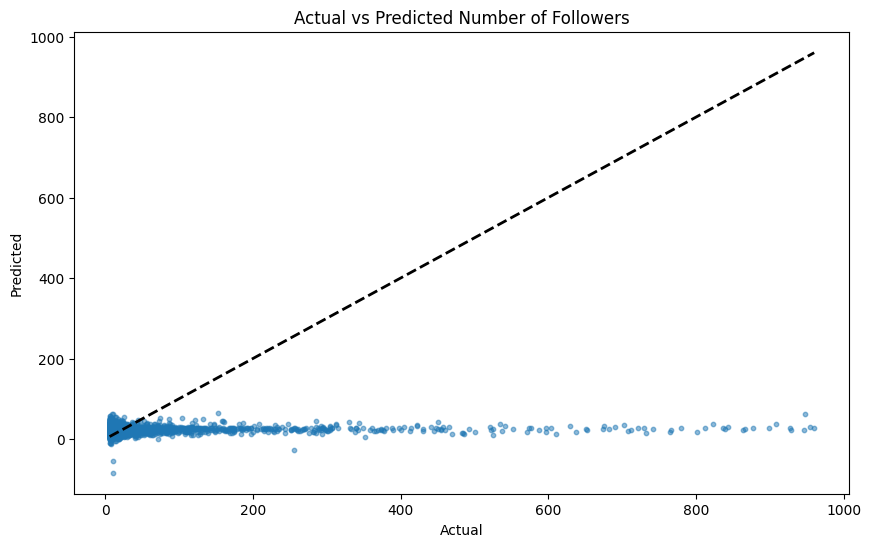

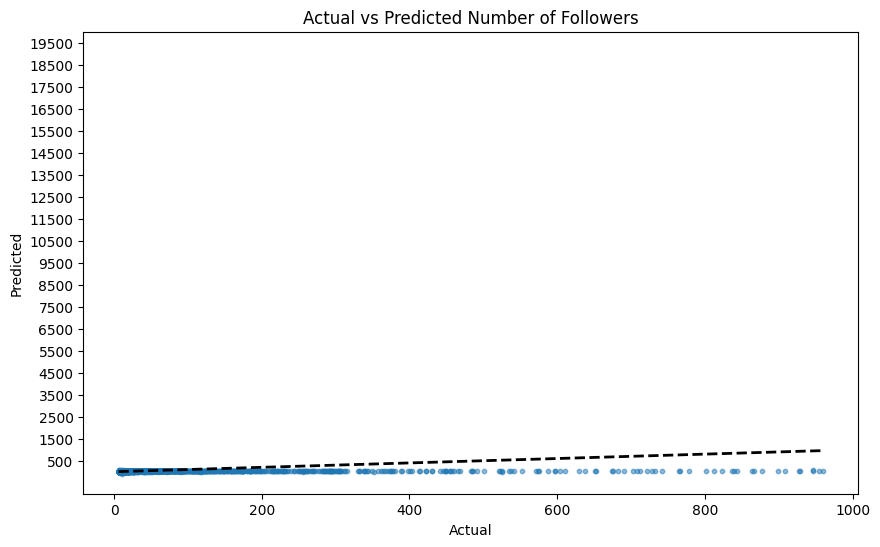

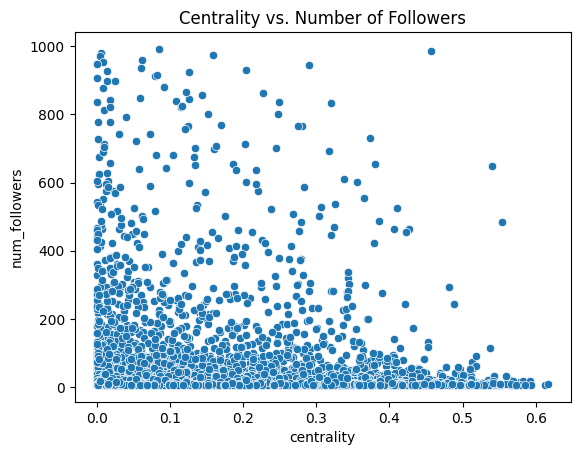

Elapsed time: 1069.0771038532257 seconds


In [201]:
# Визуализация результатов с уменьшенным масштабом точек и повышенной прозрачностью
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, s=10)  # Уменьшаем размер точек и повышаем прозрачность
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Number of Followers')
plt.show()

# Визуализация результатов с ограниченным масштабом по оси Y и установкой делений
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, s=10)  # Уменьшаем размер точек и повышаем прозрачность
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Number of Followers')
plt.ylim(-1000, 20000)  # Ограничиваем масштаб по оси Y от 500 до 20k
plt.yticks(range(500, 20001, 1000))  # Устанавливаем деления каждые 1000
plt.show()


sns.scatterplot(x='centrality', y='num_followers', data=graph_data)
plt.title('Centrality vs. Number of Followers')
plt.show()


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")